# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [54]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack,csr_matrix
from sklearn.metrics import roc_auc_score,auc
from sklearn.ensemble import GradientBoostingClassifier

import pickle

from tqdm import tqdm
import os
from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go

from collections import Counter


nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)


# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/saurav/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [55]:
import pandas
data = pandas.read_csv('preprocessed_data.csv',nrows=50000)

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [56]:
X = data
Y = data['project_is_approved']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,stratify=Y,random_state=42)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [57]:
essay_train_data = X_train['essay']
essay_test_data = X_test['essay']

# TFIDF

In [58]:
#keeping the maximum text based feature to 6500
tfidf_essay_vectorizer = TfidfVectorizer(min_df=10,max_features=6500)


#train_data_essay TFIDF fit and transform
tfidf_essay_vectorizer.fit(essay_train_data)

tfidf_essay_train = tfidf_essay_vectorizer.transform(essay_train_data)
tfidf_essay_test = tfidf_essay_vectorizer.transform(essay_test_data)

print('shape of train/test  {} {}'.format(tfidf_essay_train.shape,tfidf_essay_test.shape))

shape of train/test  (35000, 6500) (15000, 6500)


# TFIDF W2V

In [59]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039

def loadGloveModel(gloveFile):
    
    print ("Loading Glove Model")
    
    f = open(gloveFile,'r', encoding = 'utf8')
    
    model = {}
    
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    
    print ("Done.",len(model)," words loaded!")
    
    return model

In [60]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [61]:
# TF-IDF weighted Word2Vec
def Tfidf_w2v(preprocessed_essays):
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(preprocessed_essays)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    tfidf_w2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
    for sentence in preprocessed_essays: # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return np.array(tfidf_w2v_vectors)


In [62]:
tfidfw2v_essay_train = Tfidf_w2v(essay_train_data)
tfidfw2v_essay_test = Tfidf_w2v(essay_test_data)


In [63]:
tfidfw2v_essay_train = csr_matrix(tfidfw2v_essay_train)
tfidfw2v_essay_test = csr_matrix(tfidfw2v_essay_test)

# Sentiment Analysis(Essay)

In [64]:
#sentiment score features for train data
sent_pos_train = []
sent_neg_train = []
sent_neu_train = []
sent_compound_train = []
for essay in essay_train_data:
    s_score = sid.polarity_scores(essay)
    sent_neg_train.append(s_score['neg'])
    sent_neu_train.append(s_score['neu'])
    sent_pos_train.append(s_score['pos'])
    sent_compound_train.append(s_score['compound'])

In [65]:
#sentiment score features for test data
sent_pos_test = []
sent_neg_test = []
sent_neu_test = []
sent_compound_test = []
for essay in essay_test_data:
    s_score = sid.polarity_scores(essay)
    sent_neg_test.append(s_score['neg'])
    sent_neu_test.append(s_score['neu'])
    sent_pos_test.append(s_score['pos'])
    sent_compound_test.append(s_score['compound'])

In [66]:
#converting train sentiment scores into numpy array
sent_pos_train = np.array(sent_pos_train).reshape(-1,1)
sent_neg_train = np.array(sent_neg_train).reshape(-1,1)
sent_neu_train = np.array(sent_neu_train).reshape(-1,1)
sent_compound_train = np.array(sent_compound_train).reshape(-1,1)
sent_pos_train.shape

(35000, 1)

In [67]:
#converting test sentiment scores into numpy array
sent_pos_test = np.array(sent_pos_test).reshape(-1,1)
sent_neg_test = np.array(sent_neg_test).reshape(-1,1)
sent_neu_test = np.array(sent_neu_test).reshape(-1,1)
sent_compound_test = np.array(sent_compound_test).reshape(-1,1)
sent_pos_test.shape

(15000, 1)

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

# Numerical Data

In [68]:
#Normalising numerical data for better featurisation among all numerical features

normalise = Normalizer()

normalise.fit(X_train['price'].values.reshape(-1,1))

norm_price_train = normalise.transform(X_train['price'].values.reshape(-1,1)).reshape(-1,1)
norm_price_test = normalise.transform(X_test['price'].values.reshape(-1,1))
print(norm_price_train.shape)

normalise.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

norm_teacher_n_previously_posted_projects_train = normalise.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
norm_teacher_n_previously_posted_projects_test = normalise.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

(35000, 1)


# Categorical Data

**NOTE**

1. All the categorical data are response coded.


In [69]:
#this function generates the probability of being each of the classes i.e response code
def prob_value(feature_name):
    #getting total number of unique category and number of times they appear
    total_unique = X_train[ feature_name ].value_counts()
    #standard value of alpha for laplace transform
    alpha = 1
    item_score = dict()
    for cat,tot_count in total_unique.items():
            #count number of times an item is present in the feature column when the ouput is 1 or 0
            class_zero = X_train.loc[(X_train['project_is_approved'] == 0) & (X_train[ feature_name ] == cat)].shape[0]
            class_one = X_train.loc[(X_train['project_is_approved'] == 1) & (X_train[ feature_name ] == cat)].shape[0]
            
            #adding laplace smoothing with alpha
            prob_0 = float(class_zero + alpha*10) / (tot_count + 90*alpha)
            prob_1 = float(class_one + alpha*10) / (tot_count + 90*alpha)
            item_score[cat] = [prob_0,prob_1]
    return item_score


def response_code(feature_name,data):
    prob_score = prob_value(feature_name)
    feature_score = []
    for row in data[feature_name].values:
        #if the item was seen in the train data then use the scores calculated
        if row in prob_score.keys():
            feature_score.append(prob_score[row])
        #otherwise use the default probability i.e both have equal probability
        else:
            feature_score.append([0.5,0.5])
    return feature_score

In [70]:
#getting response_code for all the categorical features for both train and test data

rc_clean_category_train = np.array(response_code('clean_categories',X_train))
rc_clean_category_test = np.array(response_code('clean_categories',X_test))


rc_clean_subcategory_train = np.array(response_code('clean_subcategories',X_train))
rc_clean_subcategory_test = np.array(response_code('clean_subcategories',X_test))


rc_project_grade_category_train = np.array(response_code('project_grade_category',X_train))
rc_project_grade_category_test = np.array(response_code('project_grade_category',X_test))


rc_school_state_train = np.array(response_code('school_state',X_train))
rc_school_state_test = np.array(response_code('school_state',X_test))


rc_teacher_prefix_train = np.array(response_code('teacher_prefix',X_train))
rc_teacher_prefix_test = np.array(response_code('teacher_prefix',X_test))


In [71]:
print(rc_clean_category_train.shape)

(35000, 2)


**STACKING all the features SET 1**

In [72]:
X_train_tfidf = hstack((tfidf_essay_train,sent_pos_train,sent_neg_train,sent_neu_train,sent_compound_train,norm_price_train,norm_teacher_n_previously_posted_projects_train,rc_clean_category_train,rc_clean_subcategory_train,rc_project_grade_category_train,rc_school_state_train,rc_teacher_prefix_train))
X_test_tfidf = hstack((tfidf_essay_test,sent_pos_test,sent_neg_test,sent_neu_test,sent_compound_test,norm_price_test,norm_teacher_n_previously_posted_projects_test,rc_clean_category_test,rc_clean_subcategory_test,rc_project_grade_category_test,rc_school_state_test,rc_teacher_prefix_test))

In [73]:
print(X_train_tfidf.shape,X_test_tfidf.shape)

(35000, 6516) (15000, 6516)


**STACKING all the features SET 2**

In [74]:
X_train_tfidfw2v = hstack((tfidfw2v_essay_train,sent_pos_train,sent_neg_train,sent_neu_train,sent_compound_train,norm_price_train,norm_teacher_n_previously_posted_projects_train,rc_clean_category_train,rc_clean_subcategory_train,rc_project_grade_category_train,rc_school_state_train,rc_teacher_prefix_train))
X_test_tfidfw2v = hstack((tfidfw2v_essay_test,sent_pos_test,sent_neg_test,sent_neu_test,sent_compound_test,norm_price_test,norm_teacher_n_previously_posted_projects_test,rc_clean_category_test,rc_clean_subcategory_test,rc_project_grade_category_test,rc_school_state_test,rc_teacher_prefix_test))

In [75]:
print(X_train_tfidfw2v.shape,X_test_tfidfw2v.shape)

(35000, 316) (15000, 316)


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

# Hyper Parameter Tuning

In [24]:
param = {'max_depth':  [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}
GBDT = GradientBoostingClassifier()

model_1 = GridSearchCV(GBDT,param,cv=3,return_train_score=True,scoring='roc_auc',verbose=10)

model_2 = RandomizedSearchCV(GBDT,param,cv=3,return_train_score=True,n_jobs=-1,scoring='roc_auc',verbose=20)

In [71]:
model_1.fit(X_train_tfidf,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] max_depth=1, min_samples_split=5 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=1, min_samples_split=5, score=(train=0.690, test=0.665), total= 2.1min
[CV] max_depth=1, min_samples_split=5 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV]  max_depth=1, min_samples_split=5, score=(train=0.686, test=0.672), total= 2.2min
[CV] max_depth=1, min_samples_split=5 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.3min remaining:    0.0s


[CV]  max_depth=1, min_samples_split=5, score=(train=0.690, test=0.672), total= 2.0min
[CV] max_depth=1, min_samples_split=10 ...............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.4min remaining:    0.0s


[CV]  max_depth=1, min_samples_split=10, score=(train=0.690, test=0.665), total= 1.9min
[CV] max_depth=1, min_samples_split=10 ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.3min remaining:    0.0s


[CV]  max_depth=1, min_samples_split=10, score=(train=0.686, test=0.672), total= 1.9min
[CV] max_depth=1, min_samples_split=10 ...............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.2min remaining:    0.0s


[CV]  max_depth=1, min_samples_split=10, score=(train=0.690, test=0.672), total= 1.9min
[CV] max_depth=1, min_samples_split=100 ..............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 12.1min remaining:    0.0s


[CV]  max_depth=1, min_samples_split=100, score=(train=0.690, test=0.665), total= 1.9min
[CV] max_depth=1, min_samples_split=100 ..............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 14.0min remaining:    0.0s


[CV]  max_depth=1, min_samples_split=100, score=(train=0.686, test=0.672), total= 1.9min
[CV] max_depth=1, min_samples_split=100 ..............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 15.9min remaining:    0.0s


[CV]  max_depth=1, min_samples_split=100, score=(train=0.690, test=0.672), total= 1.9min
[CV] max_depth=1, min_samples_split=500 ..............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 17.7min remaining:    0.0s


[CV]  max_depth=1, min_samples_split=500, score=(train=0.690, test=0.665), total= 1.9min
[CV] max_depth=1, min_samples_split=500 ..............................
[CV]  max_depth=1, min_samples_split=500, score=(train=0.686, test=0.672), total= 1.9min
[CV] max_depth=1, min_samples_split=500 ..............................
[CV]  max_depth=1, min_samples_split=500, score=(train=0.690, test=0.672), total= 1.9min
[CV] max_depth=5, min_samples_split=5 ................................
[CV]  max_depth=5, min_samples_split=5, score=(train=0.889, test=0.685), total= 9.1min
[CV] max_depth=5, min_samples_split=5 ................................
[CV]  max_depth=5, min_samples_split=5, score=(train=0.897, test=0.685), total= 9.0min
[CV] max_depth=5, min_samples_split=5 ................................
[CV]  max_depth=5, min_samples_split=5, score=(train=0.895, test=0.692), total= 9.0min
[CV] max_depth=5, min_samples_split=10 ...............................
[CV]  max_depth=5, min_samples_split=10, score

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 1539.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [25]:
model_2.fit(X_train_tfidfw2v,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 63.3min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 100.8min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 133.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 170.8min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 234.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 270.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 335.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 346.2min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 411.7min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 418.2min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 422.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 424.6min
[Parallel(n_jobs=-1)]: Done  15 tasks      | 

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [73]:
print('Best value of hyperparameter for TFIDF based model max depth : {} and min sample split : {}'.format(model_1.best_params_['max_depth'],model_1.best_params_['min_samples_split']))



Best value of hyperparameter for TFIDF based model max depth : 5 and min sample split : 500


In [26]:
print('Best value of hyperparameter for TFIDF-W2V based model max depth : {} and min sample split : {}'.format(model_2.best_params_['max_depth'],model_2.best_params_['min_samples_split']))


Best value of hyperparameter for TFIDF-W2V based model max depth : 5 and min sample split : 5


# Performance of the model using heatmap (TFIDF)

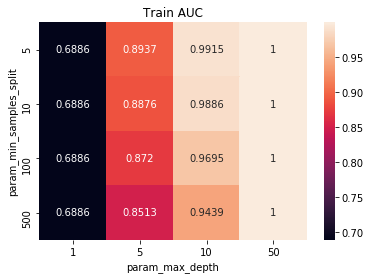

In [75]:
scores = pd.DataFrame(model_1.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score','mean_train_score']]
sns.heatmap(scores.mean_train_score, annot = True, fmt='.4g')

plt.title('Train AUC')

plt.show()

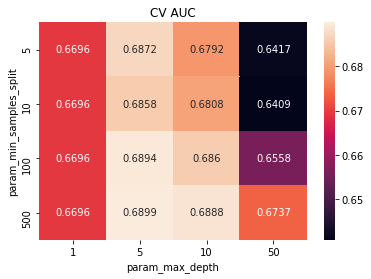

In [76]:
sns.heatmap(scores.mean_test_score, annot = True, fmt='.4g')
plt.title('CV AUC')
plt.show()

# Performance of the model using heatmap (TFIDF - W2V)


In [ ]:
scores = pd.DataFrame(model_2.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score','mean_train_score']]
sns.heatmap(scores.mean_train_score, annot = True, fmt='.4g')

plt.title('Train AUC')

plt.show()

In [ ]:
sns.heatmap(scores.mean_test_score, annot = True, fmt='.4g')
plt.title('CV AUC')
plt.show()

# ROC curve and best AUC score(TFIDF)

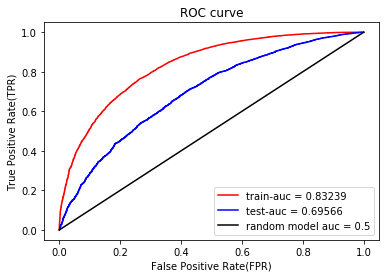

Best AUC for the model is 0.69566 


In [77]:
clf = GradientBoostingClassifier(max_depth=5,min_samples_split=500)
clf.fit(X_train_tfidf,y_train)


y_pred_train = clf.predict_proba(X_train_tfidf)
y_pred_test = clf.predict_proba(X_test_tfidf)

#taking the probabilit scores instead of the predicted label
#predict_proba returns probabilty scores which is in the 2nd column thus taking the second column
fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),5)
test_auc = round(auc(fpr_test,tpr_test),5)

plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

# Confusion Matrix (TFIDF)

In [29]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.4099031321205547 for threshold 0.854


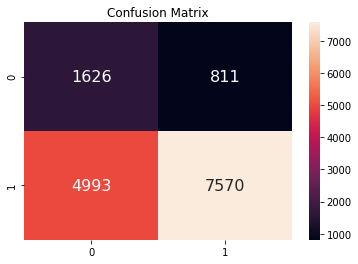

In [79]:
predicted = predict(y_pred_test[:,1],threshold_test,fpr_test,tpr_test)
confusion_matrix_test = pd.DataFrame(confusion_matrix(y_test,predicted))
sns.heatmap(confusion_matrix_test,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')
plt.show()

# ROC curve and best AUC score(TFIDF W2V)

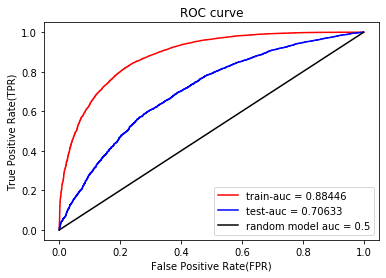

Best AUC for the model is 0.70633 


In [28]:
clf = GradientBoostingClassifier(max_depth=5,min_samples_split=5)
clf.fit(X_train_tfidfw2v,y_train)

y_pred_train = clf.predict_proba(X_train_tfidfw2v)
y_pred_test = clf.predict_proba(X_test_tfidfw2v)

#taking the probabilit scores instead of the predicted label
#predict_proba returns probabilty scores which is in the 2nd column thus taking the second column
fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),5)
test_auc = round(auc(fpr_test,tpr_test),5)

plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

# Confusion Matrix (TFIDF W2V)

the maximum value of tpr*(1-fpr) 0.42602713591451485 for threshold 0.844


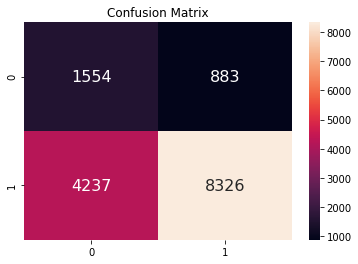

In [30]:
predicted = predict(y_pred_test[:,1],threshold_test,fpr_test,tpr_test)
confusion_matrix_test = pd.DataFrame(confusion_matrix(y_test,predicted))
sns.heatmap(confusion_matrix_test,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')
plt.show()

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [32]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names= (" Vectorizer ", " Max_depth ", " Min_sample_split "," Test -AUC ")
table.add_row([" Tf-Idf", 5 , 500 ,0.69566])
table.add_row(["Tf-Idf W2V", 5 , 5 ,0.70633])
print(table.get_string(titles = "Decision trees- Observations")) 

+--------------+-------------+--------------------+-------------+
|  Vectorizer  |  Max_depth  |  Min_sample_split  |  Test -AUC  |
+--------------+-------------+--------------------+-------------+
|    Tf-Idf    |      5      |        500         |   0.69566   |
|  Tf-Idf W2V  |      5      |         5          |   0.70633   |
+--------------+-------------+--------------------+-------------+
